In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as sm

import seaborn as sns

In [46]:
cd '~/Research/scalabm/example-model/gode-sunder/'

/Users/drpugh/Research/scalabm/example-model/gode-sunder


In [47]:
!sbt run

[info] Loading global plugins from /Users/drpugh/.sbt/0.13/plugins
[info] Updating {file:/Users/drpugh/.sbt/0.13/plugins/}global-plugins...
[info] Resolving com.jsuereth#sbt-pgp;1.0.0 ...
[info] Resolving com.jsuereth#pgp-library_2.10;1.0.0 ...
[info] Resolving org.scala-lang#scala-library;2.10.4 ...
[info] Resolving org.bouncycastle#bcpg-jdk15on;1.51 ...
[info] Resolving org.bouncycastle#bcprov-jdk15on;1.51 ...
[info] Resolving net.databinder#dispatch-http_2.10;0.8.10 ...
[info] Resolving net.databinder#dispatch-core_2.10;0.8.10 ...
[info] Resolving org.apache.httpcomponents#httpclient;4.1.3 ...
[info] Resolving org.apache.httpcomponents#httpcore;4.1.4 ...
[info] Resolving commons-logging#commons-logging;1.1.1 ...
[info] Resolving commons-codec#commons-codec;1.4 ...
[info] Resolving net.databinder#dispatch-futures_2.10;0.8.10 ...
[info] Resolving org.scala-lang#scala-actors;2.10.2 ...
[info] Resolving org.scala-sbt#sbt;0.13.8 ...
[info] Resolving org.scala-sbt#main;0.13.8 ...
[info] R

## Importing the raw JSON data

In [48]:
cd'./data'

/Users/drpugh/Research/scalabm/example-model/gode-sunder/data


In [49]:
tmp_df = pd.read_json('./Gpi2.json', orient='records')
data = tmp_df.iloc[::-1].set_index('timestamp')

In [50]:
data.head()

,askPrice,bidPrice,price,quantity
timestamp,,,,
2016-02-17 12:19:58.346,26,89,26,1
2016-02-17 12:19:58.366,67,172,67,1
2016-02-17 12:19:58.366,72,81,72,1
2016-02-17 12:19:58.366,75,157,75,1
2016-02-17 12:19:58.366,50,127,50,1


In [51]:
data.tail()

,askPrice,bidPrice,price,quantity
timestamp,,,,
2016-02-17 12:20:58.785,81,104,81,1
2016-02-17 12:20:58.785,15,68,68,1
2016-02-17 12:20:58.785,26,62,62,1
2016-02-17 12:20:58.785,56,61,56,1
2016-02-17 12:20:58.785,91,147,91,1


In [52]:
data.describe()

,askPrice,bidPrice,price,quantity
count,1292514.000000,1292514.000000,1292514.000000,1292514
mean,78.164445,121.959786,100.071043,1
std,45.017669,44.974391,31.012229,0
min,1.000000,36.000000,26.000000,1
25%,39.000000,83.000000,75.000000,1
50%,78.000000,122.000000,100.000000,1
75%,117.000000,161.000000,126.000000,1
max,170.000000,199.000000,170.000000,1


### Compute the bid-ask spread...

    spread = bidPrice - askPice

In [53]:
data['spread'] = data.bidPrice - data.askPrice

In [54]:
data.spread.describe()

count    1292514.000000
mean          43.795341
std           29.896785
min            1.000000
25%           20.000000
50%           39.000000
75%           62.000000
max          157.000000
Name: spread, dtype: float64

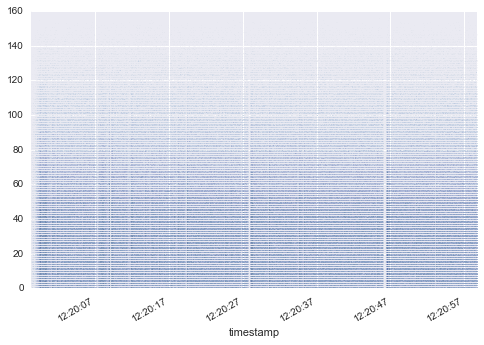

In [55]:
data.spread.plot(linestyle='none', marker='o', markersize=1, alpha=0.02)

<h2> Compute raw returns </h2>

$$ r_{t+k} = \frac{p_{t+k} - p_{t}}{p_{t}} = \frac{\Delta p_{t+k}}{p_{t}}$$ 

Note that raw returns are bounded below! Bounds on price (at least in these simulations!) are $1 \le p_t \le 200$. Therefore lower bound on raw returns is...

$$ \underline{r} = \frac{1 - 200}{200} \approx -1. $$

Similarly, then upper bound on raw returns is...

$$ \underline{r} = \frac{200 - 1}{1} = 199. $$


In [56]:
data['raw_returns'] = data.price.pct_change(periods=1)

In [57]:
data.raw_returns.describe()

count    1292513.000000
mean           0.102044
std            0.512947
min           -0.734177
25%           -0.231293
50%            0.000000
75%            0.296703
max            2.761905
Name: raw_returns, dtype: float64

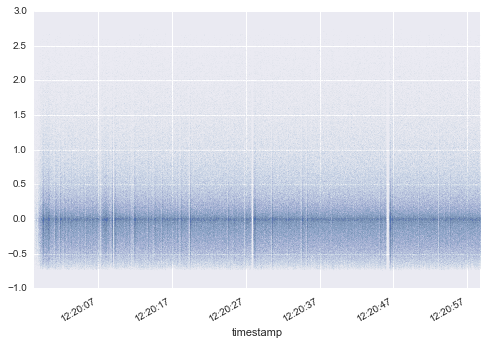

In [59]:
data.raw_returns.plot(linestyle='none', marker='o', markersize=1, alpha=0.02)
plt.show()

## Compute logarithmic returns

Starting from raw returns, $r_{t+k}$ we see that...

$$ 1 + r_{t+k} = 1 + \frac{p_{t+k} - p_t}{p_t} = \frac{p_{t+k}}{p_t} $$

...taking logs yields...

$$ \ln \big(1 + r_{t+k}\big) = \ln p_{t+k} - \ln p_t = \Delta \ln p_{t+k} $$

...since $\ln \big(1 + r_{t+k}\big) \approx r_{t+k}$ for $r << 1$ we should expect that raw and logarithmic return formulas should yields similar results for "small" returns.


In [60]:
data['log_returns'] = np.log(1 + data.raw_returns)

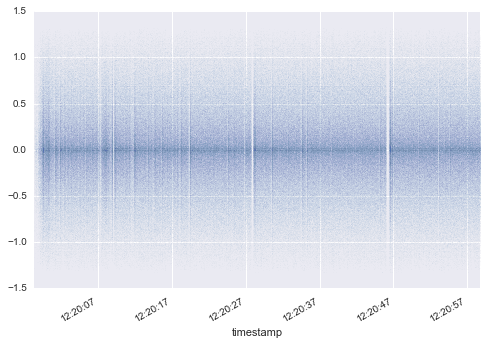

In [61]:
data.log_returns.plot(linestyle='none', marker='o', markersize=1, alpha=0.02)
plt.show()

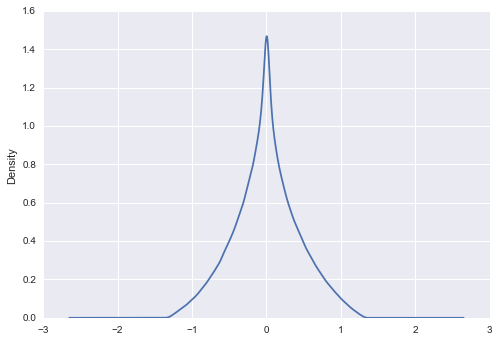

In [62]:
data.log_returns.dropna().plot(kind='kde')
plt.show()

<h3> Price impact </h3>

In [63]:
data['mid_price'] = 0.5 * (data.askPrice + data.bidPrice)

How to best measure effective size? Particularly of ask orders!

In [64]:
data['effective_size'] = data.quantity

incoming_ask_orders = data.bidPrice == data.price
data.loc[incoming_ask_orders, 'effective_size'] *= -data.loc[incoming_ask_orders, 'askPrice']

incoming_bid_orders = data.askPrice == data.price
data.loc[incoming_bid_orders, 'effective_size'] *= data.loc[incoming_bid_orders, 'bidPrice']

Compute the measure of price impact: $\Delta \ln$ `mid_price`...

In [68]:
data['price_impact'] = np.log(data.mid_price).diff()

In [71]:
data[incoming_ask_orders].head()

,askPrice,bidPrice,price,quantity,spread,raw_returns,log_returns,mid_price,effective_size,price_impact
timestamp,,,,,,,,,,
2016-02-17 12:19:58.369,99,123,123,1,24,0.051282,0.050010,111.0,-99,-0.134657
2016-02-17 12:19:58.370,75,109,109,1,34,-0.174242,-0.191454,92.0,-75,-0.387183
2016-02-17 12:19:58.370,4,85,85,1,81,-0.220183,-0.248697,44.5,-4,-0.726299
2016-02-17 12:19:58.371,27,92,92,1,65,-0.365517,-0.454945,59.5,-27,-0.992318
2016-02-17 12:19:58.371,103,145,145,1,42,0.576087,0.454945,124.0,-103,0.734305


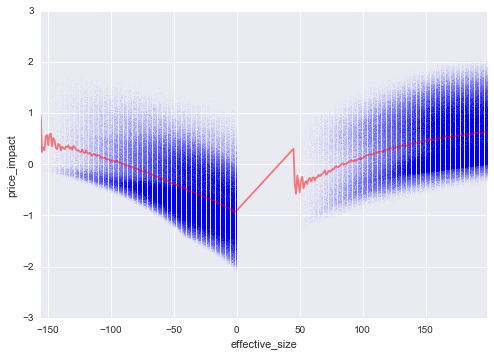

In [70]:
# incoming bid orders
fig, ax = plt.subplots(1, 1)
grouped_data = data.groupby("effective_size")
grouped_data.price_impact.mean().plot(color='r', alpha=0.5, ax=ax)
ax.scatter(data.effective_size, data.price_impact, edgecolor='b', s=1, alpha=0.01)
ax.set_ylabel("price_impact")
plt.show()

## Cumulative distributions

In [31]:
ecdfs = {} 
for column_name in ['raw_returns', 'log_returns']:
    ecdfs[column_name] = sm.distributions.ECDF(data[column_name].abs())

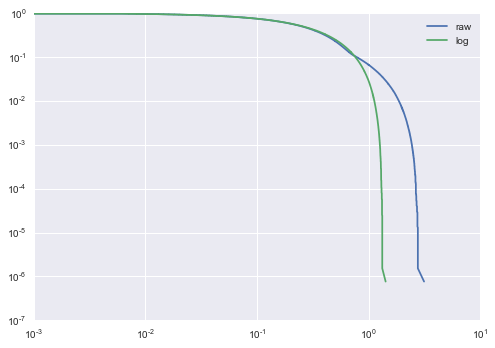

In [32]:
plt.plot(ecdfs['raw_returns'].x, 1 - ecdfs['raw_returns'].y, label='raw')
plt.plot(ecdfs['log_returns'].x, 1 - ecdfs['log_returns'].y, label='log')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()